In [2]:
from transformers import pipeline
from PIL import Image
import requests
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import matplotlib.pyplot as plt
import sys
from skimage import filters, color, morphology
from skimage.segmentation import flood, flood_fill
import skimage
import math
import os
import random
from sklearn.cluster import KMeans
import scipy

/user/georg.eckardt/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Depth Model
pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")

# Load Sam
model_type = "vit_b"
sam_checkpoint = "model/"+model_type+".pth"

torch.cuda.set_device(0)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to("cuda")
predictor = SamPredictor(sam)


In [4]:
# Functions
def calc_center( mask ):
    coords = np.where(mask==True)
    x = coords[0].sum() / coords[0].shape
    y = coords[1].sum() / coords[1].shape
    return int(y), int(x)

def calc_iou(im_1, im_2):
    intersection = np.logical_and(im_1, im_2)
    union = np.logical_or(im_1,im_2)

    return np.sum(intersection)/np.sum(union)

def calc_best_subset(masks, num_masks, min_masks):
    # PERFORMANCE BOOST: Sort out masks with very high overlap and try the out later
    # Sort out masks with clear cut boundaries
    min_value = float("inf")
    min_arr = []

    # add empty masks
    for i in range(num_masks-min_masks):
        masks.append(np.zeros((128,128)))
    
    min_value, min_arr = iteration_layer(min_value, min_arr, [], num_masks, masks)

    return min_arr

def mkdir(s):
    try:
        os.mkdir(s)
    except:
        pass

def three_dim(x):
    return np.stack( ( x.copy()*234, x.copy()*345, x.copy()*567 ), 2).astype(np.uint8)  

def three_dim_bw(x):
    return np.stack( ( x.copy()*255, x.copy()*255, x.copy()*255 ), 2).astype(np.uint8)  

def create_video(s):
    return cv2.VideoWriter(s,cv2.VideoWriter_fourcc(*'mp4v'), 12, (128,128))

def iteration_layer(min_value, min_arr, current_arr, level, masks, starting_index=0):
    if level == 0:
        uni_map = np.zeros((128,128))
        for x in range(len(current_arr)):
            uni_map += masks[current_arr[x]] 
        full_score = np.absolute(uni_map-1).sum()   
        # check for new best
        if full_score < min_value:
            min_arr = current_arr.copy()
            del current_arr[-1]
            return full_score, min_arr
        else:
            del current_arr[-1]
            return min_value, min_arr
    
    for i in range(starting_index,len(masks)):
        current_arr.append(i)
        min_value, min_arr = iteration_layer(min_value, min_arr, current_arr, level-1, masks, i+1)
        
    try:
        del current_arr[-1]
    except:
        pass
    return min_value, min_arr

def create_sobel(frame):
    return np.array(filters.sobel(frame))

def calc_centers_colormean(regions,frame):
    center = []
    color_mean = []
        
    for k in range(np.unique(regions).shape[0]):
        area = regions == k
        size = area.sum()
        center.append( calc_center(area) )
        color_mean.append( (area  * ((frame[..., 0] + frame[..., 1] + frame[..., 2] )/3).astype(np.uint8)).sum()/ size )
    
    return center, color_mean

def display_pointers(center, image):
    for x in range(len(center)):
            image = cv2.circle( image, (int(center[x][0]), int(center[x][1])), 3, (255, 255, 255) )
    return image

def display_bb(bbs, image):
    for bb in bbs:
            p1 = (bb[0][1], bb[0][0])
            p2 = (bb[1][1], bb[1][0])
            image = cv2.rectangle(image, p1, p2, (255,255,255), 1)

    return image

def bw_frame(frame):
    return (frame[...,0] + frame[...,1] + frame[...,2])/3

def normalise(x):
    x = np.array(x)
    std = x.std()
    if std == 0:
        return (x-x.mean())
    else:
        return (x-x.mean())/std

def point_dist(p1,p2):
    return math.sqrt( (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2  )

# Average distance between points is 1
def calc_normalize(center):
    centerx = np.array([ x  for x,y in center])
    centery = np.array([ y  for x,y in center])
    norm_center = np.stack((centerx.copy(), centery.copy()), axis=-1)

    distance = []
    for i,p1 in enumerate(center):
        for j,p2 in enumerate(center):
            if i != j:
                distance.append( point_dist(p1,p2) )
    
    distance = np.array(distance)

    return norm_center/distance.mean()

def calc_centerdepth(center, dist):
    centerdist = []
    for x in center:
        centerdist.append(dist[x[0]][x[1]])
    return centerdist

def calc_div_matrix(color_mean):
    size = len(color_mean)
    color_mean = np.array(color_mean)
    matrix = np.zeros((size,size))
                      
    for x in range(size):
        matrix[x] = color_mean - color_mean[x]
    
    return np.absolute( matrix )

def calc_dist_matrix(points):
    size = points.shape[0]
    centerx = points[:,0]
    centery = points[:,1]

    matrix = np.zeros((size,size))
                      
    for x in range(size):
        matrix[x] = np.sqrt((centerx - centerx[x])**2 + (centery - centery[x])**2)
    
    return np.absolute( matrix )

def get_bb(images):
    bb = []
    for im in images:
        x, y = np.where(im != 0)
        bb.append( ( (x.min(), y.min()), (x.max(), y.max() ) ) )
        
    return bb

def calc_depth_mean(depth, mask_arr):
    mean_depths = []
    for mask in mask_arr:
        area = depth * mask
        mean = area.sum() / (area != 0).sum()
        max_diff = area.max()-area.min()
        mean_depths.append( (mean, max_diff) )

    return mean_depths

# unify masks
def unify_masks_by_iou(mask_all, iou_thresh):
    len_mask_all = len(mask_all)
    iou_err = np.zeros((len_mask_all,len_mask_all))

    for n in range(len_mask_all):
        for m in range(n):
            if n != m:
                iou = calc_iou(mask_all[n], mask_all[m])
                iou_err[n][m] = iou
                iou_err[m][n] = iou

    remove_list = []
    for n in range(len_mask_all):
        for m in range(len_mask_all):
            if n != m and n not in remove_list and iou_err[n][m] > iou_thresh:
                mask_all[n] = np.logical_or(mask_all[n],mask_all[m])
                remove_list.append(m)
    
    # remove remove_list
    new_masks = []
    for x in range(len_mask_all):
        if x not in remove_list:
            new_masks.append(mask_all[x])
    
    return new_masks

def background_removal(masks, mask_depth_vis, threshhold_depth):
    mean = mask_depth_vis[:,1].mean()
    foreground_masks = []
    for i,x in enumerate(mask_depth_vis):
        if scipy.stats.norm(mean, 0.2).pdf(x[0]) > threshhold_depth:
            foreground_masks.append(masks[i])
            
    return foreground_masks

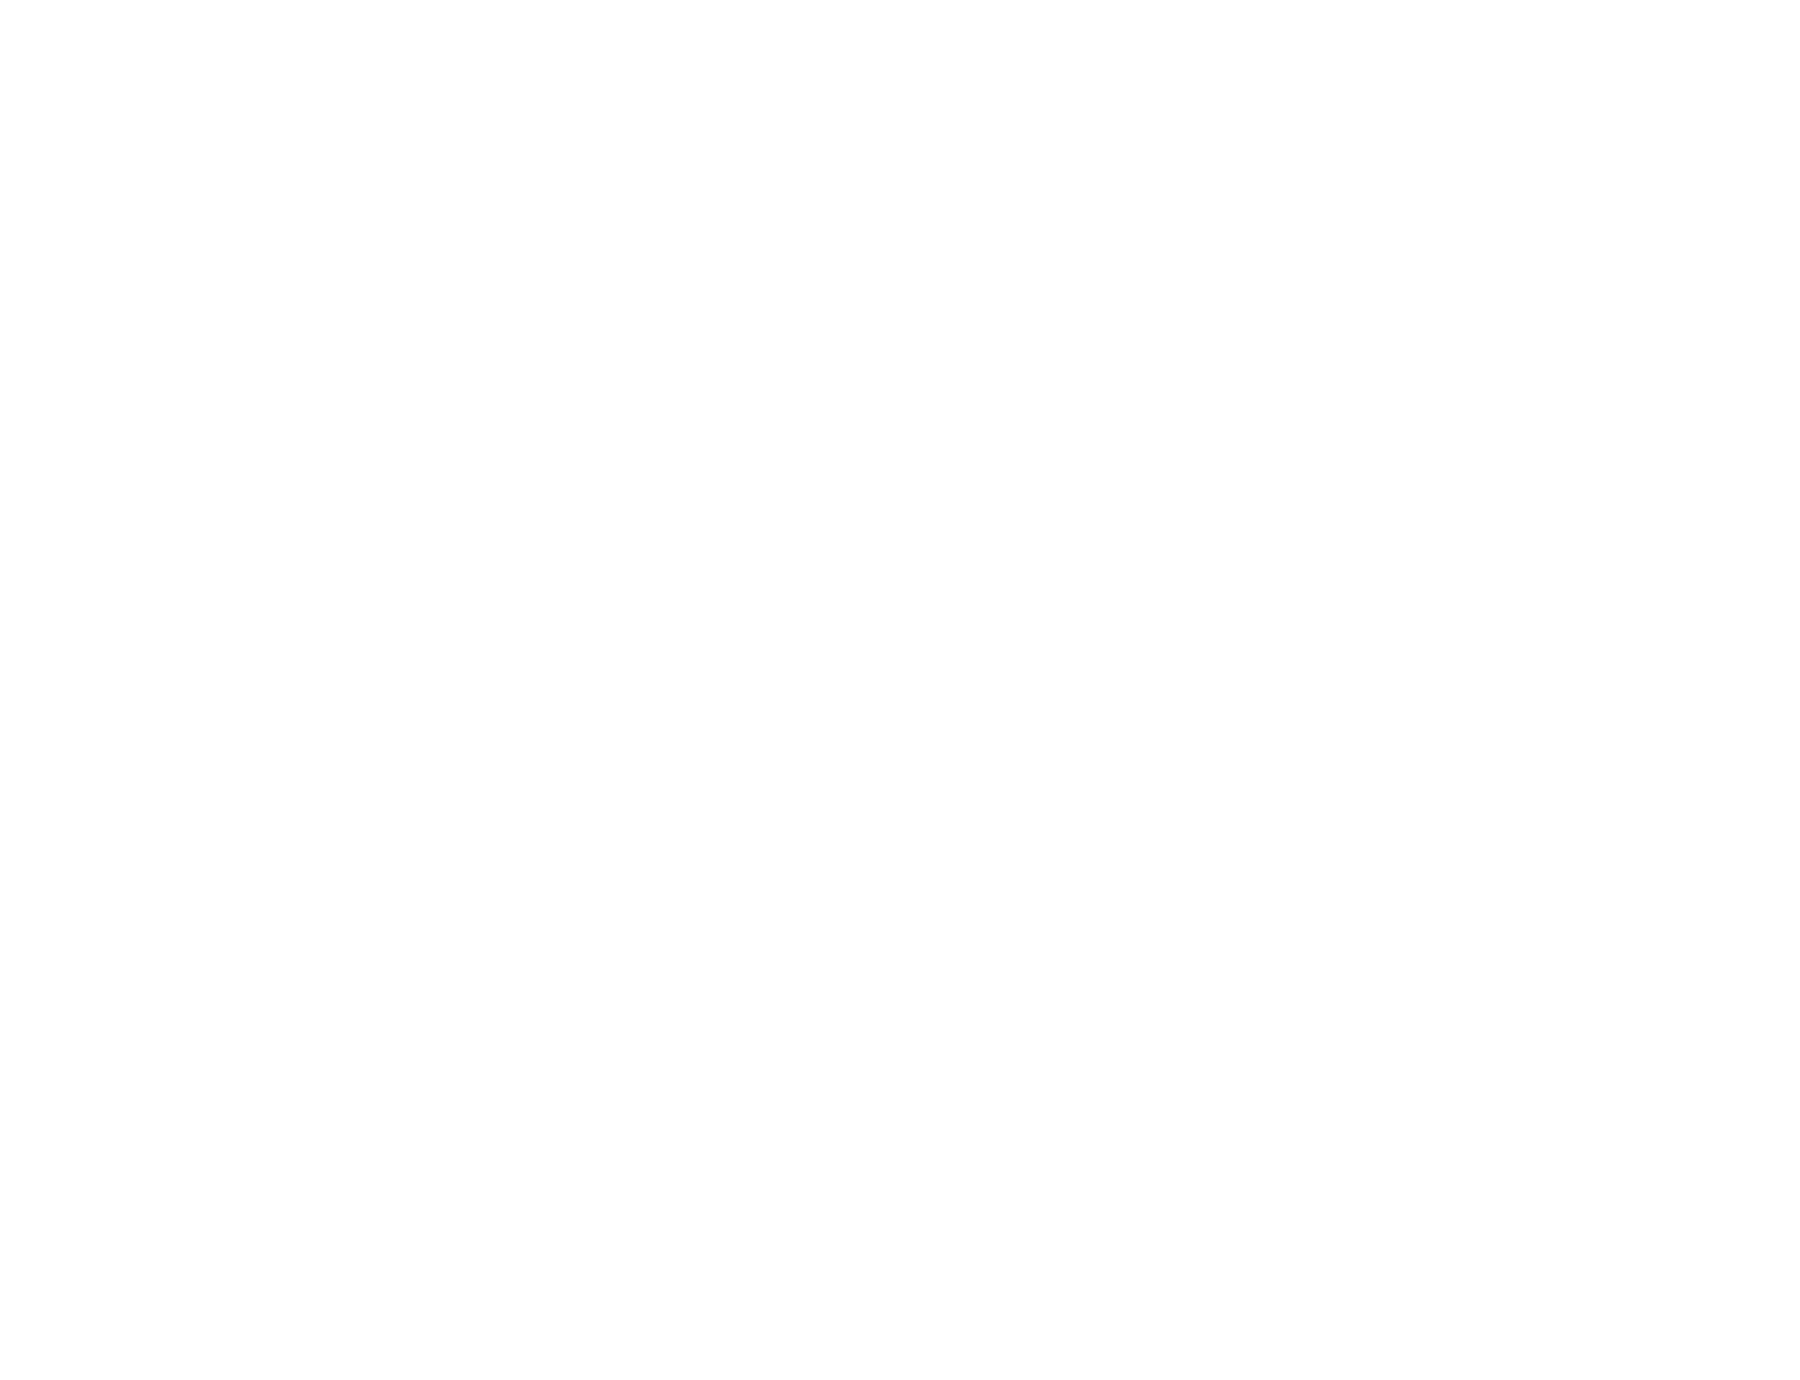

In [10]:
def get_results( selected_image, fig, num, iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth):
    error = []

    i = selected_image
    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')
    annotation = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')

    end_masks = []

    j = 0
    frame = data[0]
    bw_image = bw_frame( frame.copy() )
    norm_bw = normalise( bw_image.copy() )
    an = annotation[j]

    fig.add_subplot(3,4,num)
    #plt.imshow(frame)
    plt.axis("off")

    # predict the depth values
    depth_vals = np.array(pipe(Image.fromarray(bw_image.copy()))["depth"])

    sobel = create_sobel(norm_bw.copy())
    
    fig.add_subplot(3,4,num+1)
    #plt.imshow(sobel)
    plt.axis("off")
    
    sobel = np.digitize(sobel, bins=[sobel.mean()]).astype(np.uint8)
    
    fig.add_subplot(3,4,num+2)
    #plt.imshow(sobel)
    plt.axis("off")

    regions = skimage.morphology.label(sobel,1)
    
    fig.add_subplot(3,4,num+3)
    #plt.imshow(three_dim(regions))
    plt.axis("off")

    center, color_mean = calc_centers_colormean(regions.copy(), frame.copy())

    all_centers = display_pointers(center.copy(), frame.copy())
    #plt.imshow(all_centers)

    save_regions = 0

    while len(center) > number_of_masks:
        centerdepth = normalise(calc_centerdepth(center, depth_vals))
        norm_center = normalise(calc_normalize(center.copy()))

        dis_mat = calc_div_matrix(centerdepth)
        col_mat = calc_div_matrix(color_mean)
        cen_mat = calc_dist_matrix(norm_center)

        dis = lam_dis * math.e**(-lam_dis * dis_mat)
        col = lam_col * math.e**(-lam_col * col_mat)
        cen = lam_cen * math.e**(-lam_cen * cen_mat)

        uni = ( dis + col + cen )/3
        uni *= np.identity(uni.shape[0]) == False           # remove center values 
        

        for j in range(num_masks_removal):
            if len(center)-j > number_of_masks:
                maxi = np.unravel_index(uni.argmax(), uni.shape)
                uni[maxi[0]][maxi[1]] = 0
                regions += (regions == maxi[0])*(maxi[1]-maxi[0])
                regions = np.digitize(regions, bins=np.unique(regions))-1
                save_regions = regions.copy()
        
        center, color_mean = calc_centers_colormean(regions, frame.copy())
    
    #plt.imshow(three_dim(save_regions))
    save_center = center.copy()
    
    # Predict the Masks
    mask_all = []
    score_all = []
    predictor.set_image(frame.copy())
    for point in center:
        point = np.expand_dims(np.array(point), axis=0)
        mask, score, _  = predictor.predict( point_coords=point, point_labels=[1])
        mask_all.append(mask[0])
        score_all.append(score[0])

    all_centers = display_pointers(center.copy(), frame.copy())
    #plt.imshow(all_centers)
    
    # check for the largest cluster | remove all smaller cluster
    for m, mask in enumerate(mask_all):
        mask_regions = (skimage.morphology.label(mask,background=-1,connectivity=1)+1) * mask
        largest_mask = 0
        size = 0

        for ind in range(1, mask_regions.max()+2):
            area = (mask_regions == ind).sum()
            if area > size:
                largest_mask = ind
                size = area
        
        mask_all[m] = (mask_regions == largest_mask)
    
    # get upper/lower and left/right bounds
    bb = get_bb(mask_all)


    for x, mask in enumerate(mask_all):
        save = display_bb([bb[x]],three_dim(mask))
    
    

    new_bb = []
    old_bb = []
    for c, ((x1, y1), (x2, y2)) in enumerate(bb):
        if (x2-x1)*(y2-y1) < bb_max_size:
            new_bb.append( [y1, x1, y2, x2] )
            old_bb.append( bb[c] )
    
    #save = display_bb(old_bb,frame.copy())
    #plt.imshow(save)
    
    bb_num = np.array( new_bb )
    bb_num = torch.from_numpy(bb_num).to("cuda")

    # WHAT TO DO IF THERE ARE NO BOXES
    transformed_boxes = predictor.transform.apply_boxes_torch(bb_num, frame.shape[:2])
    
    try:
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        masks = masks.cpu().numpy().squeeze()
    except:
        masks = [np.zeros((128,128))]

    # merge masks with high iou
    masks = unify_masks_by_iou(list(masks), iou_error)
    # sort masks by size (smallest first)
    masks.sort( key = lambda masks: masks.sum() )
    
    # Foreground Background Distingtion (take mean of mean depths of all masks and then model normal distirbution with std as learnable parameter )
    np_mask_depth = np.array(calc_depth_mean(normalise(depth_vals.copy()), masks))
    np_mask_depth +=  np_mask_depth.min()*-1
    mask_depth_vis = np_mask_depth / np_mask_depth.max()

    '''
    final2 = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final2 == 0) * mask
        deep = mask_depth_vis[x][0]
        final2 = final2 + non_overlap * (x+1)
    plt.imshow(final2)
    '''

    l_masks = len(masks)
    masks = background_removal(masks, mask_depth_vis, threshhold_depth)
    removed_masks = l_masks-len(masks)
    
    # add masks together
    final = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final == 0) * mask
        deep = mask_depth_vis[x][0]
        final = final + non_overlap * (x+1)

    error.append(calc_iou(final,an.squeeze()))
    end_masks.append(final)
    #plt.imshow(final)
    sys.stdout.flush()

    return removed_masks
    #return np.array(error)

sys.stdout.flush()

iou_error = 0.6999767575931171
lam_dis = 0.5155753946424606
lam_col = 1.4193375111975206
lam_cen = 0.9949265265390193
number_of_masks = 88.5
bb_max_size = 3709.046470782817
threshhold_depth = 0.01191918304719054
num_masks_removal = 3


fig = plt.figure(figsize=(9.1, 7), dpi=200)
for i,x in enumerate((0,1,3)):
    get_results(x, fig, i*4+1,  iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth)

fig.tight_layout()

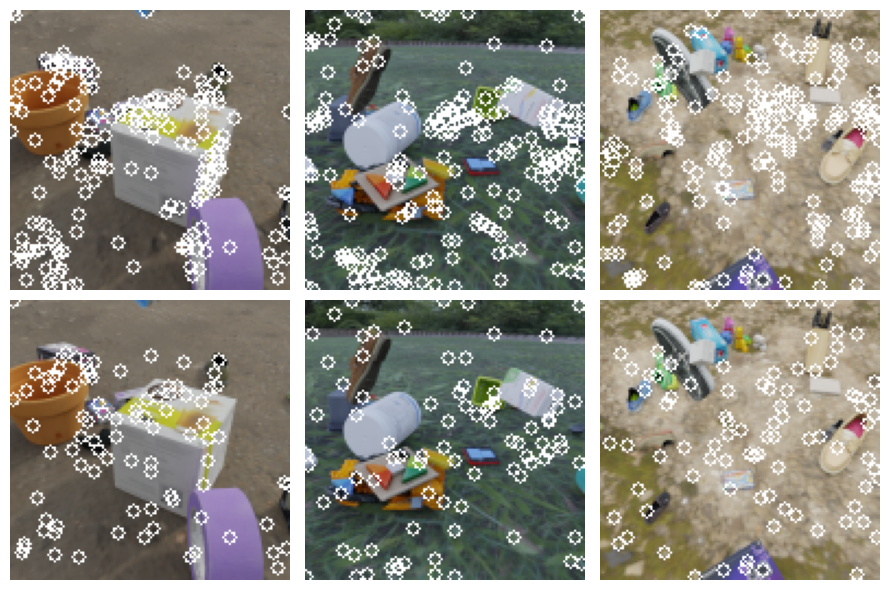

In [6]:
def get_results( selected_image, fig, num, iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth):
    error = []

    i = selected_image
    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')
    annotation = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')

    end_masks = []

    j = 0
    frame = data[0]
    bw_image = bw_frame( frame.copy() )
    norm_bw = normalise( bw_image.copy() )
    an = annotation[j]

    # predict the depth values
    depth_vals = np.array(pipe(Image.fromarray(bw_image.copy()))["depth"])

    sobel = create_sobel(norm_bw.copy())
    
    sobel = np.digitize(sobel, bins=[sobel.mean()]).astype(np.uint8)


    regions = skimage.morphology.label(sobel,1)

    center, color_mean = calc_centers_colormean(regions.copy(), frame.copy())

    all_centers = display_pointers(center.copy(), frame.copy())
    
    fig.add_subplot(2,3,num)
    plt.imshow(all_centers)
    plt.axis("off")

    save_regions = 0

    while len(center) > number_of_masks:
        centerdepth = normalise(calc_centerdepth(center, depth_vals))
        norm_center = normalise(calc_normalize(center.copy()))

        dis_mat = calc_div_matrix(centerdepth)
        col_mat = calc_div_matrix(color_mean)
        cen_mat = calc_dist_matrix(norm_center)

        dis = lam_dis * math.e**(-lam_dis * dis_mat)
        col = lam_col * math.e**(-lam_col * col_mat)
        cen = lam_cen * math.e**(-lam_cen * cen_mat)

        uni = ( dis + col + cen )/3
        uni *= np.identity(uni.shape[0]) == False           # remove center values 
        

        for j in range(num_masks_removal):
            if len(center)-j > number_of_masks:
                maxi = np.unravel_index(uni.argmax(), uni.shape)
                uni[maxi[0]][maxi[1]] = 0
                regions += (regions == maxi[0])*(maxi[1]-maxi[0])
                regions = np.digitize(regions, bins=np.unique(regions))-1
                save_regions = regions.copy()
        
        center, color_mean = calc_centers_colormean(regions, frame.copy())
    
    #plt.imshow(three_dim(save_regions))
    save_center = center.copy()
    
    # Predict the Masks
    mask_all = []
    score_all = []
    predictor.set_image(frame.copy())
    for point in center:
        point = np.expand_dims(np.array(point), axis=0)
        mask, score, _  = predictor.predict( point_coords=point, point_labels=[1])
        mask_all.append(mask[0])
        score_all.append(score[0])

    all_centers = display_pointers(center.copy(), frame.copy())
    
    fig.add_subplot(2,3,num+3)
    plt.imshow(all_centers)
    plt.axis("off")
    #plt.imshow(all_centers)

    '''
    fig = plt.figure(figsize=(7, 7), dpi=200)
    for x in range(len(mask_all)):
        fig.add_subplot(11,8,x+1)
        plt.imshow(mask_all[x])
        plt.axis("off")
    fig.tight_layout()
    print(len(mask_all))
    '''
    
    # check for the largest cluster | remove all smaller cluster
    for m, mask in enumerate(mask_all):
        mask_regions = (skimage.morphology.label(mask,background=-1,connectivity=1)+1) * mask
        largest_mask = 0
        size = 0

        for ind in range(1, mask_regions.max()+2):
            area = (mask_regions == ind).sum()
            if area > size:
                largest_mask = ind
                size = area
        
        mask_all[m] = (mask_regions == largest_mask)
    
    # get upper/lower and left/right bounds
    bb = get_bb(mask_all)


    for x, mask in enumerate(mask_all):
        save = display_bb([bb[x]],three_dim(mask))

    new_bb = []
    old_bb = []
    for c, ((x1, y1), (x2, y2)) in enumerate(bb):
        if (x2-x1)*(y2-y1) < bb_max_size:
            new_bb.append( [y1, x1, y2, x2] )
            old_bb.append( bb[c] )
    
    #save = display_bb(old_bb,frame.copy())
    #plt.imshow(save)
    
    bb_num = np.array( new_bb )
    bb_num = torch.from_numpy(bb_num).to("cuda")

    # WHAT TO DO IF THERE ARE NO BOXES
    transformed_boxes = predictor.transform.apply_boxes_torch(bb_num, frame.shape[:2])
    
    try:
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        masks = masks.cpu().numpy().squeeze()
    except:
        masks = [np.zeros((128,128))]

    # merge masks with high iou
    masks = unify_masks_by_iou(list(masks), iou_error)
    # sort masks by size (smallest first)
    masks.sort( key = lambda masks: masks.sum() )
    
    # Foreground Background Distingtion (take mean of mean depths of all masks and then model normal distirbution with std as learnable parameter )
    np_mask_depth = np.array(calc_depth_mean(normalise(depth_vals.copy()), masks))
    np_mask_depth +=  np_mask_depth.min()*-1
    mask_depth_vis = np_mask_depth / np_mask_depth.max()

    '''
    final2 = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final2 == 0) * mask
        deep = mask_depth_vis[x][0]
        final2 = final2 + non_overlap * (x+1)
    plt.imshow(final2)
    '''

    l_masks = len(masks)
    masks = background_removal(masks, mask_depth_vis, threshhold_depth)
    removed_masks = l_masks-len(masks)
    
    # add masks together
    final = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final == 0) * mask
        deep = mask_depth_vis[x][0]
        final = final + non_overlap * (x+1)

    error.append(calc_iou(final,an.squeeze()))
    end_masks.append(final)
    #plt.imshow(final)
    sys.stdout.flush()

    return removed_masks
    #return np.array(error)

sys.stdout.flush()

iou_error = 0.6999767575931171
lam_dis = 0.5155753946424606
lam_col = 1.4193375111975206
lam_cen = 0.9949265265390193
number_of_masks = 88.5
bb_max_size = 3709.046470782817
threshhold_depth = 0.01191918304719054
num_masks_removal = 3


fig = plt.figure(figsize=(9, 6), dpi=100)
for i,x in enumerate((247, 184, 137)):
    get_results(x, fig, i+1,  iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth)

fig.tight_layout()

88
88


/tmp/ipykernel_186403/530294683.py:189: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.tight_layout()


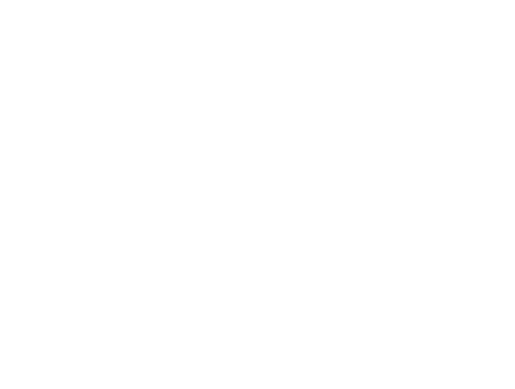

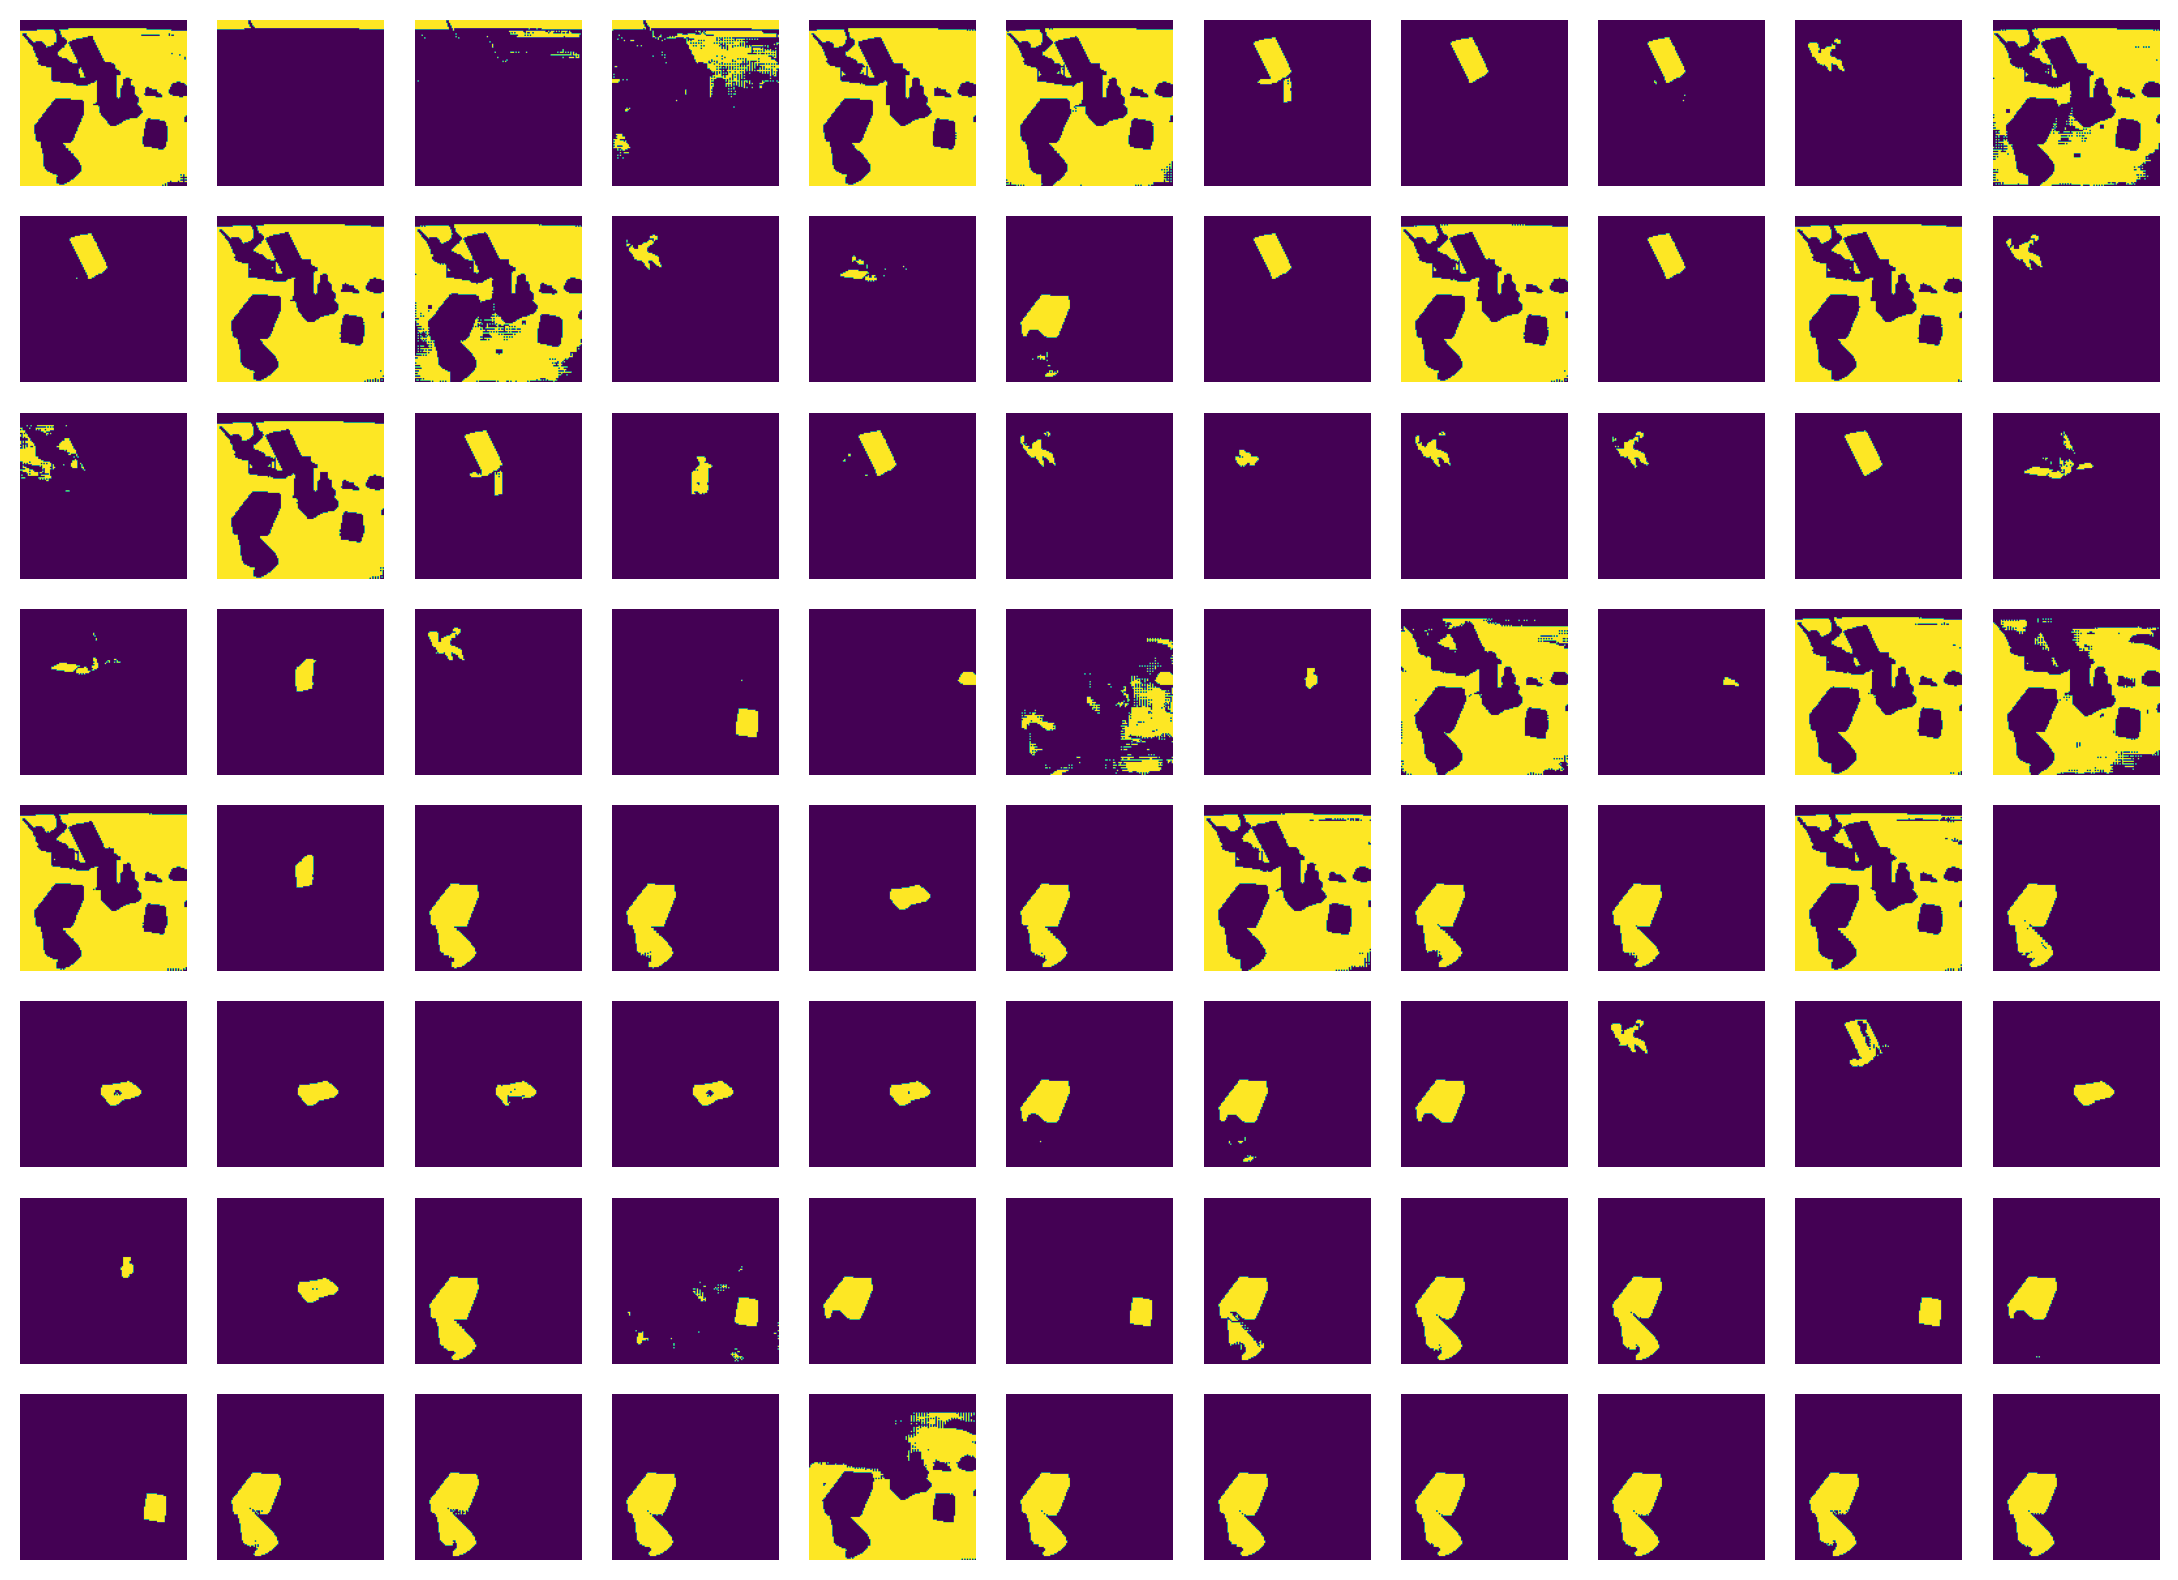

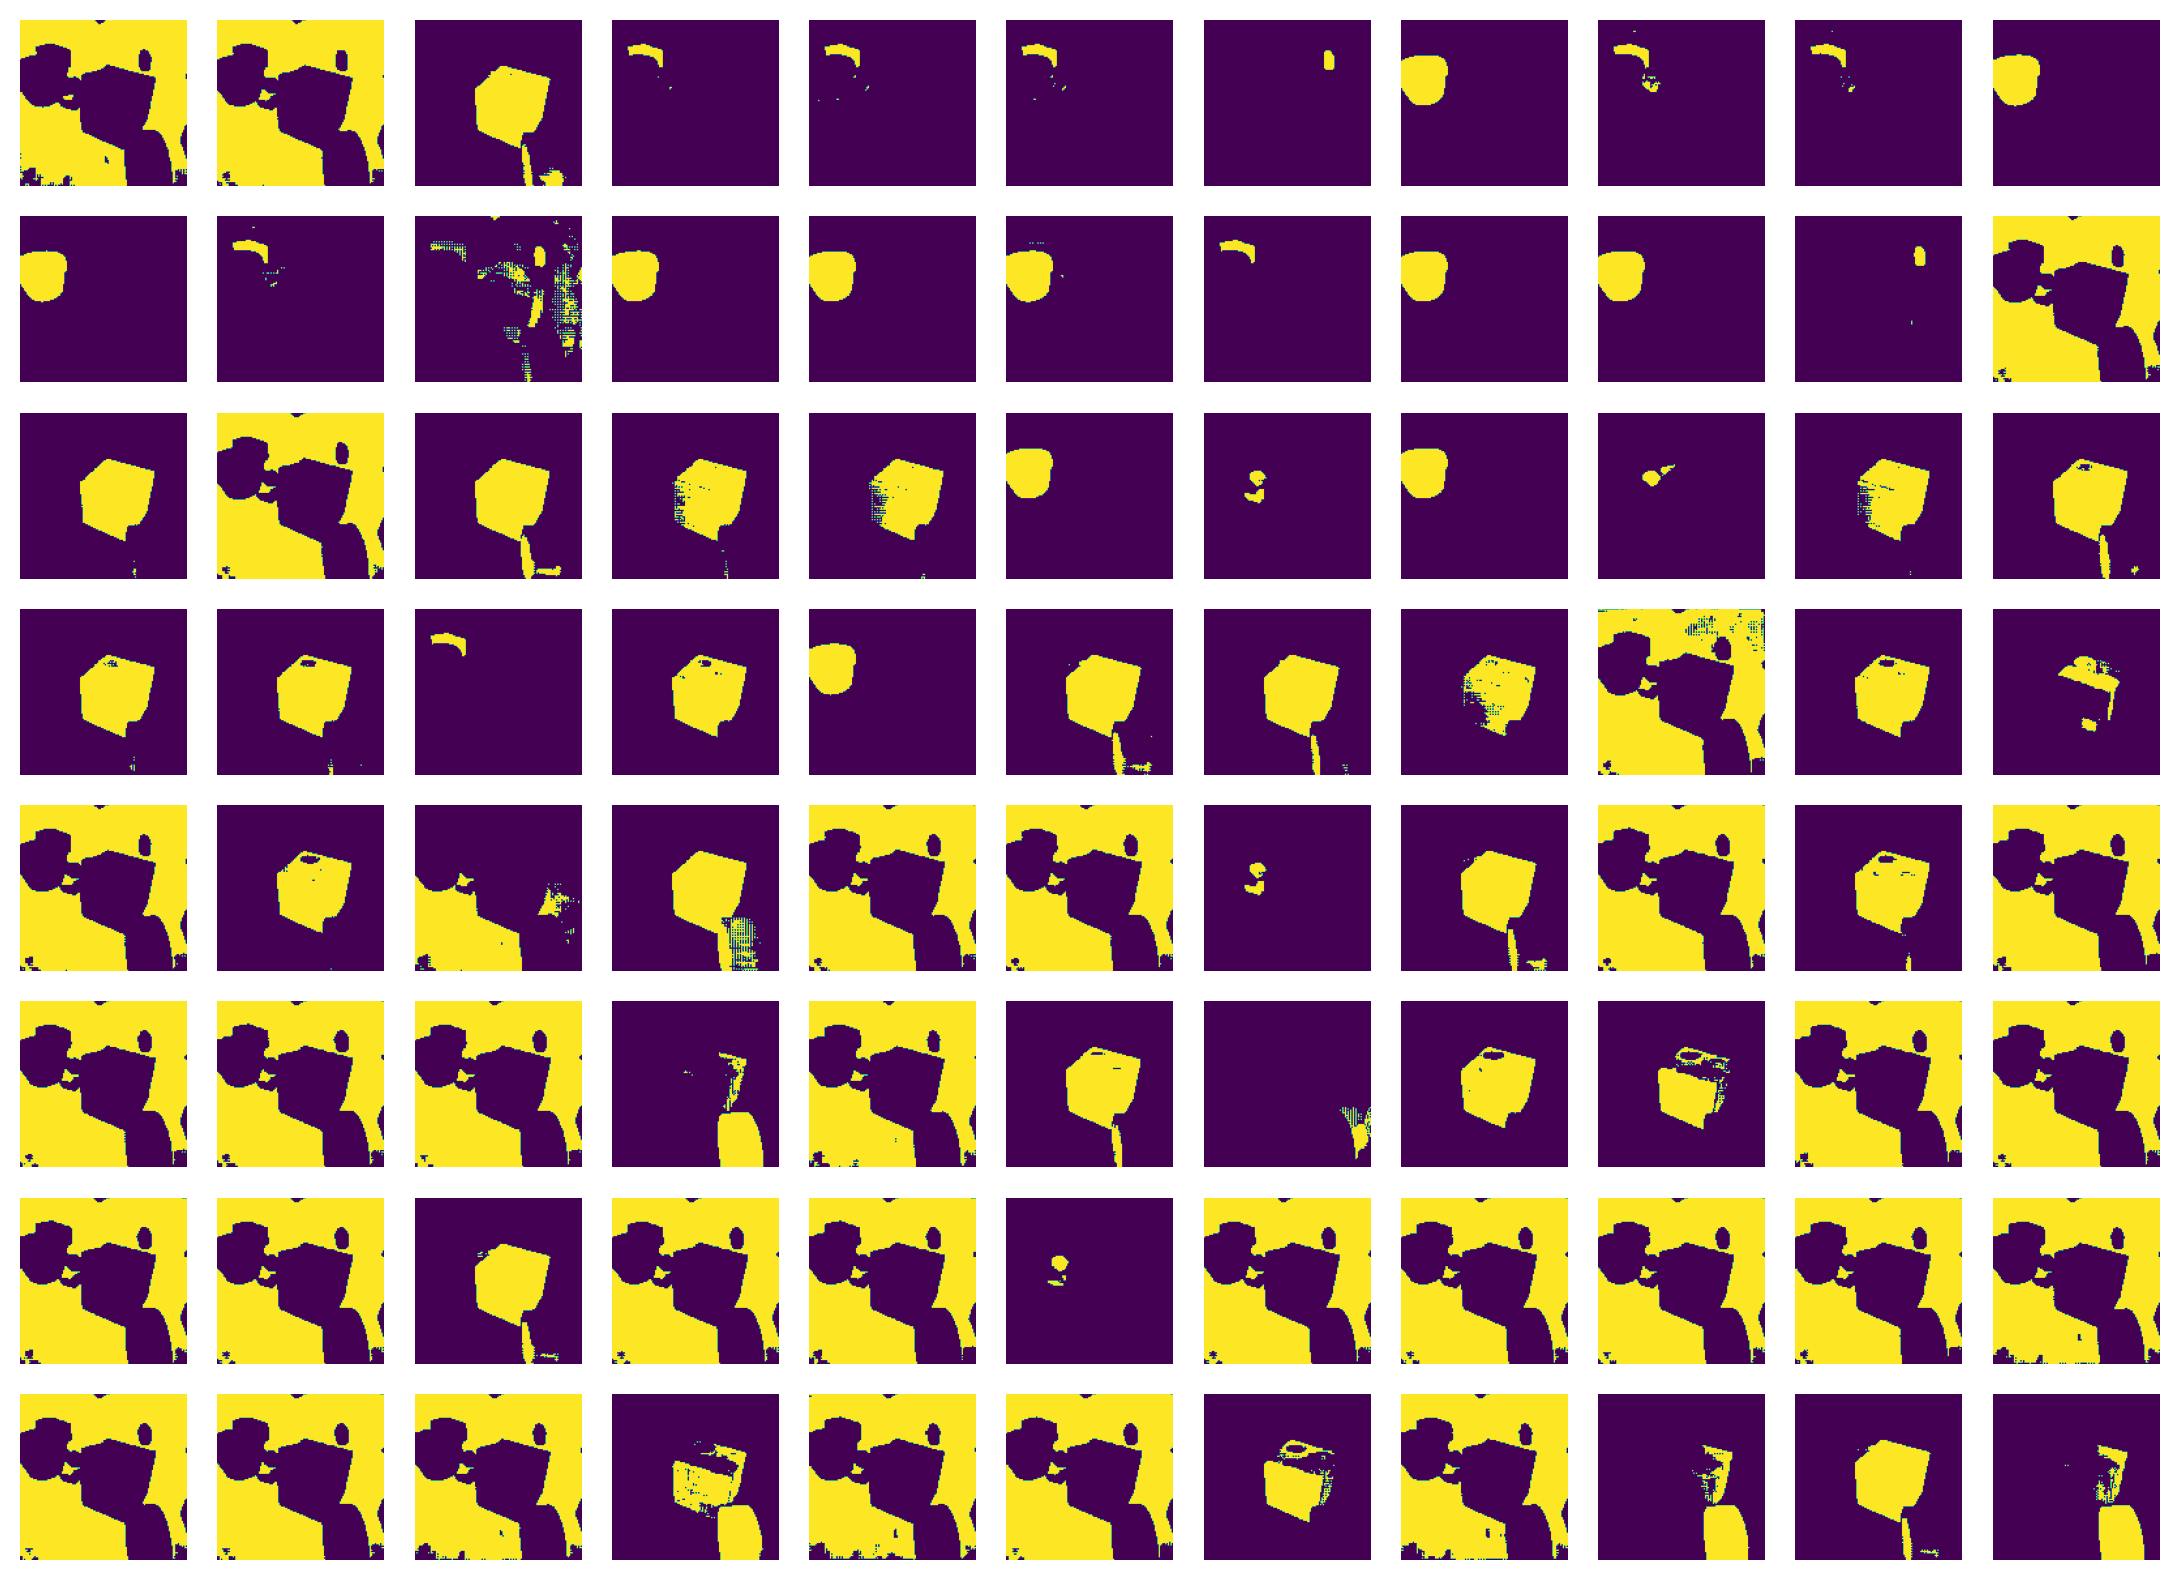

In [15]:
def get_results( selected_image, fig, num, iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth):
    error = []

    i = selected_image
    data = np.load('data/MOVIE/videos/'+str(i)+'.npy')
    annotation = np.load('data/MOVIE/segmentations/'+str(i)+'.npy')

    end_masks = []

    j = 0
    frame = data[0]
    bw_image = bw_frame( frame.copy() )
    norm_bw = normalise( bw_image.copy() )
    an = annotation[j]

    # predict the depth values
    depth_vals = np.array(pipe(Image.fromarray(bw_image.copy()))["depth"])

    sobel = create_sobel(norm_bw.copy())
    
    sobel = np.digitize(sobel, bins=[sobel.mean()]).astype(np.uint8)


    regions = skimage.morphology.label(sobel,1)

    center, color_mean = calc_centers_colormean(regions.copy(), frame.copy())

    all_centers = display_pointers(center.copy(), frame.copy())

    save_regions = 0

    while len(center) > number_of_masks:
        centerdepth = normalise(calc_centerdepth(center, depth_vals))
        norm_center = normalise(calc_normalize(center.copy()))

        dis_mat = calc_div_matrix(centerdepth)
        col_mat = calc_div_matrix(color_mean)
        cen_mat = calc_dist_matrix(norm_center)

        dis = lam_dis * math.e**(-lam_dis * dis_mat)
        col = lam_col * math.e**(-lam_col * col_mat)
        cen = lam_cen * math.e**(-lam_cen * cen_mat)

        uni = ( dis + col + cen )/3
        uni *= np.identity(uni.shape[0]) == False           # remove center values 
        

        for j in range(num_masks_removal):
            if len(center)-j > number_of_masks:
                maxi = np.unravel_index(uni.argmax(), uni.shape)
                uni[maxi[0]][maxi[1]] = 0
                regions += (regions == maxi[0])*(maxi[1]-maxi[0])
                regions = np.digitize(regions, bins=np.unique(regions))-1
                save_regions = regions.copy()
        
        center, color_mean = calc_centers_colormean(regions, frame.copy())
    
    #plt.imshow(three_dim(save_regions))
    save_center = center.copy()
    
    # Predict the Masks
    mask_all = []
    score_all = []
    predictor.set_image(frame.copy())
    for point in center:
        point = np.expand_dims(np.array(point), axis=0)
        mask, score, _  = predictor.predict( point_coords=point, point_labels=[1])
        mask_all.append(mask[0])
        score_all.append(score[0])

    all_centers = display_pointers(center.copy(), frame.copy())
    
    fig.add_subplot(2,3,num+3)
    #plt.imshow(all_centers)
    plt.axis("off")
    #plt.imshow(all_centers)

    
    fig = plt.figure(figsize=(11, 8), dpi=200)
    for x in range(len(mask_all)):
        fig.add_subplot(8,11,x+1)
        plt.imshow(mask_all[x])
        plt.axis("off")
    fig.tight_layout()
    print(len(mask_all))
    
    # check for the largest cluster | remove all smaller cluster
    for m, mask in enumerate(mask_all):
        mask_regions = (skimage.morphology.label(mask,background=-1,connectivity=1)+1) * mask
        largest_mask = 0
        size = 0

        for ind in range(1, mask_regions.max()+2):
            area = (mask_regions == ind).sum()
            if area > size:
                largest_mask = ind
                size = area
        
        mask_all[m] = (mask_regions == largest_mask)
    
    # get upper/lower and left/right bounds
    bb = get_bb(mask_all)


    for x, mask in enumerate(mask_all):
        save = display_bb([bb[x]],three_dim(mask))

    new_bb = []
    old_bb = []
    for c, ((x1, y1), (x2, y2)) in enumerate(bb):
        if (x2-x1)*(y2-y1) < bb_max_size:
            new_bb.append( [y1, x1, y2, x2] )
            old_bb.append( bb[c] )
    
    #save = display_bb(old_bb,frame.copy())
    #plt.imshow(save)
    
    bb_num = np.array( new_bb )
    bb_num = torch.from_numpy(bb_num).to("cuda")

    # WHAT TO DO IF THERE ARE NO BOXES
    transformed_boxes = predictor.transform.apply_boxes_torch(bb_num, frame.shape[:2])
    
    try:
        masks, _, _ = predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )
        masks = masks.cpu().numpy().squeeze()
    except:
        masks = [np.zeros((128,128))]

    # merge masks with high iou
    masks = unify_masks_by_iou(list(masks), iou_error)
    # sort masks by size (smallest first)
    masks.sort( key = lambda masks: masks.sum() )
    
    # Foreground Background Distingtion (take mean of mean depths of all masks and then model normal distirbution with std as learnable parameter )
    np_mask_depth = np.array(calc_depth_mean(normalise(depth_vals.copy()), masks))
    np_mask_depth +=  np_mask_depth.min()*-1
    mask_depth_vis = np_mask_depth / np_mask_depth.max()

    
    final2 = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final2 == 0) * mask
        deep = mask_depth_vis[x][0]
        final2 = final2 + non_overlap * (x+1)

    

    l_masks = len(masks)
    masks = background_removal(masks, mask_depth_vis, threshhold_depth)
    removed_masks = l_masks-len(masks)
    
    # add masks together
    final = np.zeros((128,128))
    for x, mask in enumerate(masks):
        non_overlap = (final == 0) * mask
        deep = mask_depth_vis[x][0]
        final = final + non_overlap * (x+1)

    error.append(calc_iou(final,an.squeeze()))
    end_masks.append(final)
    #plt.imshow(final)
    sys.stdout.flush()

    return removed_masks
    #return np.array(error)

sys.stdout.flush()

iou_error = 0.6999767575931171
lam_dis = 0.5155753946424606
lam_col = 1.4193375111975206
lam_cen = 0.9949265265390193
number_of_masks = 88.5
bb_max_size = 3709.046470782817
threshhold_depth = 0.01191918304719054
num_masks_removal = 3



for i,x in enumerate((0,247)):
    get_results(x, fig, i+1,  iou_error, lam_dis, lam_col, lam_cen, num_masks_removal, number_of_masks, bb_max_size, threshhold_depth)

fig.tight_layout()

- Yolo on movie (x)
- optical flow on movie & shi tomasi (x)
- otsu on movie (x)
- best x sam mask performance
- sobel filters (x)
- point fusing (x)
- final bounding boxes movie own approach (x)